# Use Azimuth to predict cell types in the dataset with scRNA-seq

## Build reference Seurat object

In [2]:
library(Seurat)
library(SeuratData)
library(Azimuth)
library(Matrix)

Attaching SeuratObject

── Installed datasets ───────────────────────────────────── SeuratData v0.2.2 ──

✔ fetusref 1.0.0                        


────────────────────────────────────── Key ─────────────────────────────────────

✔ Dataset loaded successfully
❯ Dataset built with a newer version of Seurat than installed
❓ Unknown version of Seurat installed


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Attaching shinyBS



In [8]:
ds <- 'fetusref.SeuratData'
type <- 'azimuth'
path <- file.path(system.file(package=ds), type)

In [9]:
ref.names <- list(map = 'ref.Rds', ann = 'idx.annoy')
mapref <- file.path(path, ref.names$map)
annref <- file.path(path, ref.names$ann)
exists <- file.exists(c(mapref, annref))

In [11]:
map <- readRDS(file = mapref)
map[["refdr.annoy.neighbors"]] <- LoadAnnoyIndex(object = map[["refdr.annoy.neighbors"]], file = annref)

In [27]:
ad <- Tool(object = map, slot = "AzimuthReference")
plotref.dr <- slot(object = ad, name = "plotref")
cm <- sparseMatrix(i = 1, j = 1, x = 0, dims = c(1, nrow(x = plotref.dr)), dimnames = list("placeholder", Cells(x = plotref.dr)))
plot <- CreateSeuratObject(counts = cm)
plot[["refUMAP"]] <- plotref.dr
plot <- AddMetaData(object = plot, metadata = Misc(object = plotref.dr, slot = "plot.metadata"))
gc(verbose = FALSE)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3812740,203.7,6393462,341.5,6393462,341.5
Vcells,81260039,620.0,138003825,1052.9,138003166,1052.9


In [38]:
saveRDS(list(map = map, plot = plot), '../output/fetus_ref_list.rds')

## Create Seurat object of input scRNA-seq data, filtering, and normalization

In [ ]:
ori_data <- Read10X(data.dir = "../data/raw/EB1_count/EB1-count/outs/gene_activities_matrix/", gene.column = 1)
ori_obj <- CreateSeuratObject(counts = ori_data, project = "EB1", min.cells = 3, min.features = 200)

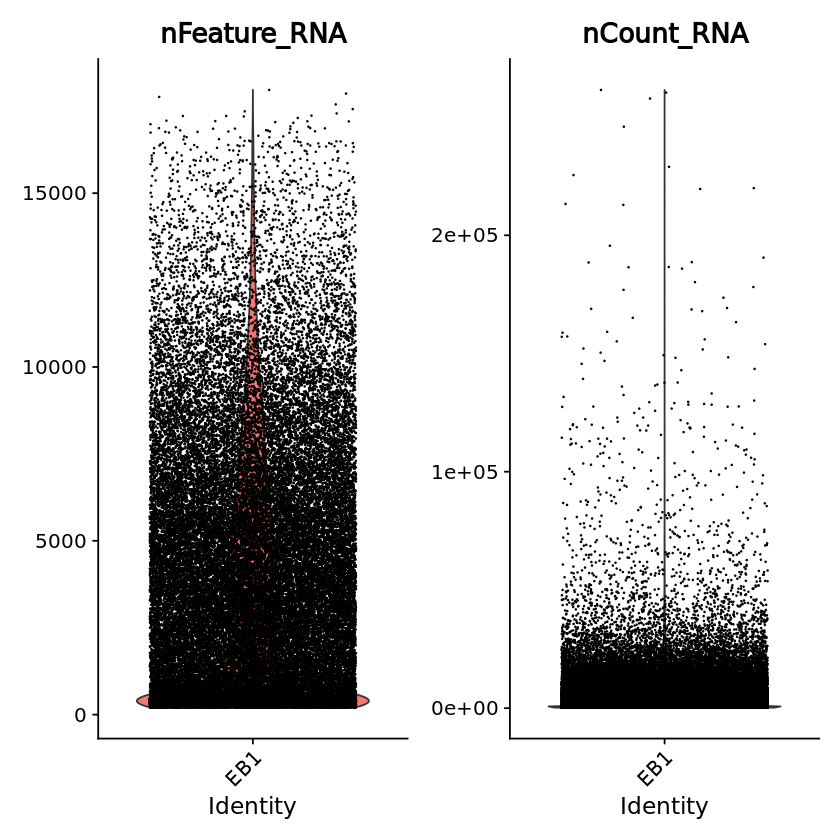

In [4]:
VlnPlot(ori_obj, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)

In [5]:
ori_obj <- subset(ori_obj, subset = nFeature_RNA > 200 & nFeature_RNA < 12000 & nCount_RNA < 40000)

In [7]:
ori_obj <- NormalizeData(ori_obj)
ori_obj <- FindVariableFeatures(ori_obj, selection.method = "vst", nfeatures = 2000)

In [8]:
top10 <- head(VariableFeatures(ori_obj), 10)
top10

[1] "ANKRD30A"   "COL22A1"    "FAM135B"    "ZNF98"      "TPTE"      
 [6] "PHACTR3"    "ANKRD30B"   "ZIM2"       "STS"        "AC016991.1"

In [9]:
saveRDS(ori_obj, '../data/EB1_count_normalized.rds')

## Use Azimuth to predict cell types in the input data based on reference

In [2]:
library(Seurat)
library(SeuratData)
library(Azimuth)
library(Matrix)
library(patchwork)

Attaching SeuratObject

── Installed datasets ───────────────────────────────────── SeuratData v0.2.2 ──

✔ fetusref 1.0.0                        


────────────────────────────────────── Key ─────────────────────────────────────

✔ Dataset loaded successfully
❯ Dataset built with a newer version of Seurat than installed
❓ Unknown version of Seurat installed


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Attaching shinyBS



In [3]:
ori_obj <- readRDS('../data/EB1_count_normalized.rds')

In [4]:
ori_obj <- RunAzimuth(ori_obj, reference = "fetusref")

An AzimuthData object - reference version: 1.0.0 
Contains 3 meta.data field(s) to transfer.

Warning message:
“Overwriting miscellanous data for model”
detected inputs from HUMAN with id type Gene.name

reference rownames detected HUMAN with id type Gene.name

Using reference SCTModel to calculate pearson residuals

Determine variable features

Setting min_variance to:  -Inf

Calculating residuals of type pearson for 2275 genes



  |======================================================================| 100%


Set default assay to refAssay

Normalizing query using reference SCT model

Projecting cell embeddings

Finding query neighbors

Finding neighborhoods

Finding anchors

	Found 9798 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscoreannotation.l1_ to predictionscoreannotationl1_”
Predicting cell labels

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscoreannotation.l2_ to predictionscoreannotationl2_”
Predicting cell labels


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Warning message:
“Keys should be one or mor

In [5]:
saveRDS(ori_obj, '../data/EB1_count_reference.rds')

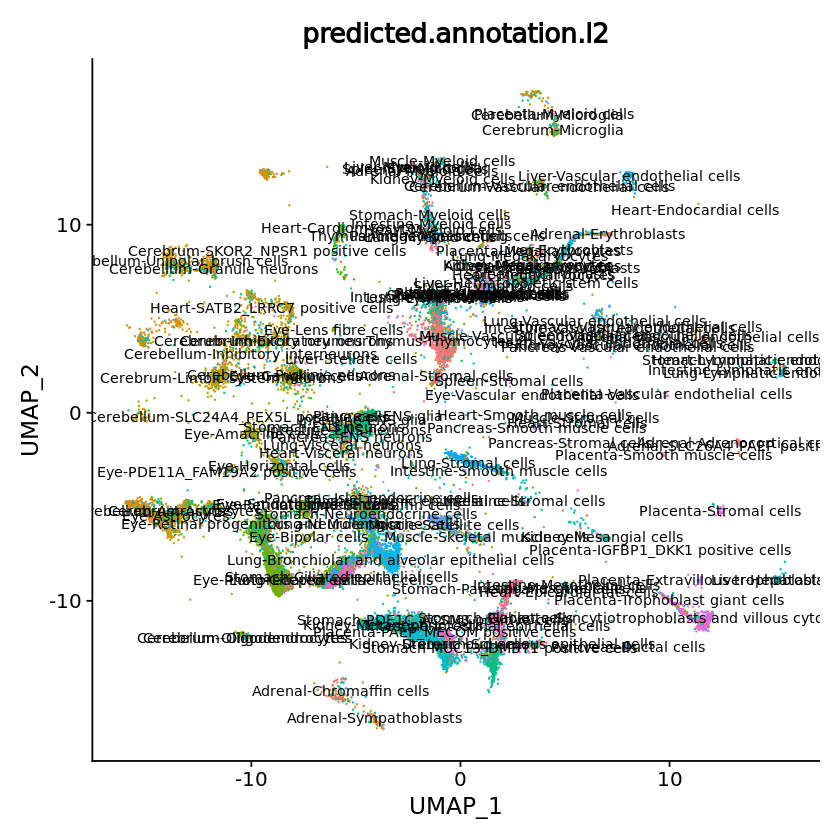

In [6]:
DimPlot(ori_obj, group.by = "predicted.annotation.l2", label = TRUE, label.size = 3) + NoLegend()

## Sample input scRNA-seq dataset to get initial features of genes

In [2]:
library(Seurat)
library(Matrix)

Attaching SeuratObject



In [3]:
ori_obj <- readRDS('../data/EB1_count_reference.rds')

In [8]:
sample_cells <- sample(x = nrow(ori_obj), size = 10000, replace = FALSE)
sample_obj <- ori_obj[, sample_cells]

In [9]:
obs <- data.frame(sample_obj@meta.data)
var <- data.frame(gene_short_name = rownames(sample_obj@assays$RNA@data))

In [10]:
Matrix::writeMM(sample_obj@assays$RNA@data, "../data/EB1_count.mtx")

NULL

In [11]:
write.table(obs, '../data/EB1_obs.txt', sep = '\t', quote = F, row.names = F, col.names = T)
write.table(var, '../data/EB1_var.txt', sep = '\t', quote = F, row.names = F, col.names = T)